In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/homeappliance/AppEnergyEfficient.csv
/kaggle/input/nanumfont/NanumGothic.ttf


# 1. Library Import

In [2]:
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib import font_manager, rc

### Kaggle 환경에서 matplotlib 한글 사용 준비
plt.rcParams['axes.unicode_minus'] = False
fontpath = '/kaggle/input/nanumfont/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=fontpath, size=12)
mpl.font_manager._rebuild()

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 2. Dataset

In [3]:
app = pd.read_csv("/kaggle/input/homeappliance/AppEnergyEfficient.csv", encoding='CP949')
app.head()

,신청번호,품목명,모델명,등급,최대소비전력량,용량,시간당 이산화탄소 배출량(g),연간 에너지 비용
0,101010036,전기냉장고(구),SRD271AN,최저소비효율미달,37.2,267,NaN,NaN
1,101010037,전기냉장고(구),김치나이스 200S,최저소비효율미달,21.9,140.8,NaN,NaN
2,101010038,전기냉장고(구),SRD150AN,최저소비효율미달,33.7,145,NaN,NaN
3,101010039,전기냉장고(구),FRB-1580,최저소비효율미달,33.7,145,NaN,NaN
4,101010043,전기냉장고(구),SR-527A,보통,43.9,524,NaN,NaN


In [4]:
app.columns

Index(['신청번호', '품목명', '모델명', '등급', '최대소비전력량', '용량', '시간당 이산화탄소 배출량(g)',
       '연간 에너지 비용'],
      dtype='object')

In [5]:
### 김치냉장고 품목만 추출해서 DataFrame 생성
KmchFridge = app[app['품목명']=='김치냉장고'][['등급','최대소비전력량','연간 에너지 비용']]

### 오류를 방지하기 위해 DataFrame의 새로운 Index 지정
KmchFridge_ReIdx = KmchFridge.reset_index()[['등급','최대소비전력량','연간 에너지 비용']]
KmchFridge_ReIdx.head()

,등급,최대소비전력량,연간 에너지 비용
0,2,25.30,19000
1,2,25.28,19000
2,2,25.28,19000
3,1,23.74,16000
4,1,28.41,21000


## 2-1. Null Data Check

In [6]:
KmchFridge_ReIdx.isnull().sum()

등급           0
최대소비전력량      0
연간 에너지 비용    0
dtype: int64

In [7]:
### 김치냉장고의 에너지소비효율은 5등급으로 이루어져 있음
KmchFridge['등급'].unique()

array(['2', '1', '4', '5', '3'], dtype=object)

## 2-2. Data Subset
> ### 1) KmchFridge_part
> ### 2) KmchFridge_cleaned  => outlier 제거

In [8]:
### Clustering을 위해 '최대소비전력량' 과 '연간 에너지 비용' column만을 추출
KmchFridge_part = KmchFridge_ReIdx[['최대소비전력량','연간 에너지 비용']]
KmchFridge_part.head()

,최대소비전력량,연간 에너지 비용
0,25.30,19000
1,25.28,19000
2,25.28,19000
3,23.74,16000
4,28.41,21000


# 3. Dendrogram

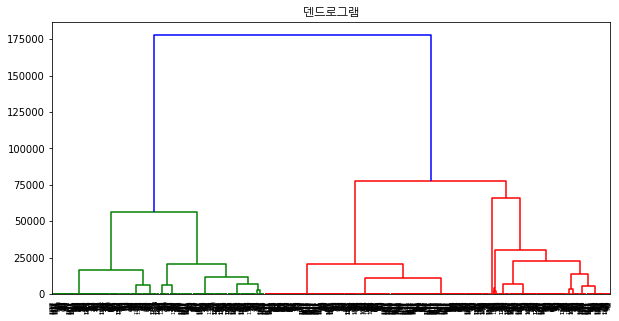

In [9]:
plt.figure(figsize=(10,5))
link_dist = linkage(KmchFridge_part, metric='euclidean', method='ward')
dendrogram(link_dist, labels=KmchFridge_part.index)
plt.title('덴드로그램', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))
plt.show()

# 4. Clustering (KmchFridge_part)

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(KmchFridge_part)

print(kmeans.n_clusters)
centers = kmeans.cluster_centers_

5


In [11]:
KmchFridge_part['클러스터'] = kmeans.labels_
KmchFridge_part.head()

,최대소비전력량,연간 에너지 비용,클러스터
0,25.30,19000,4
1,25.28,19000,4
2,25.28,19000,4
3,23.74,16000,1
4,28.41,21000,4


In [12]:
### str 타입과 int 타입간 비교 및 연산이 불가하여 datatype을 int로 변경
for i in range(len(KmchFridge_part)):
    KmchFridge_part['연간 에너지 비용'][i] = int(KmchFridge_part['연간 에너지 비용'][i])

## 4-1. Clustering Visualization 

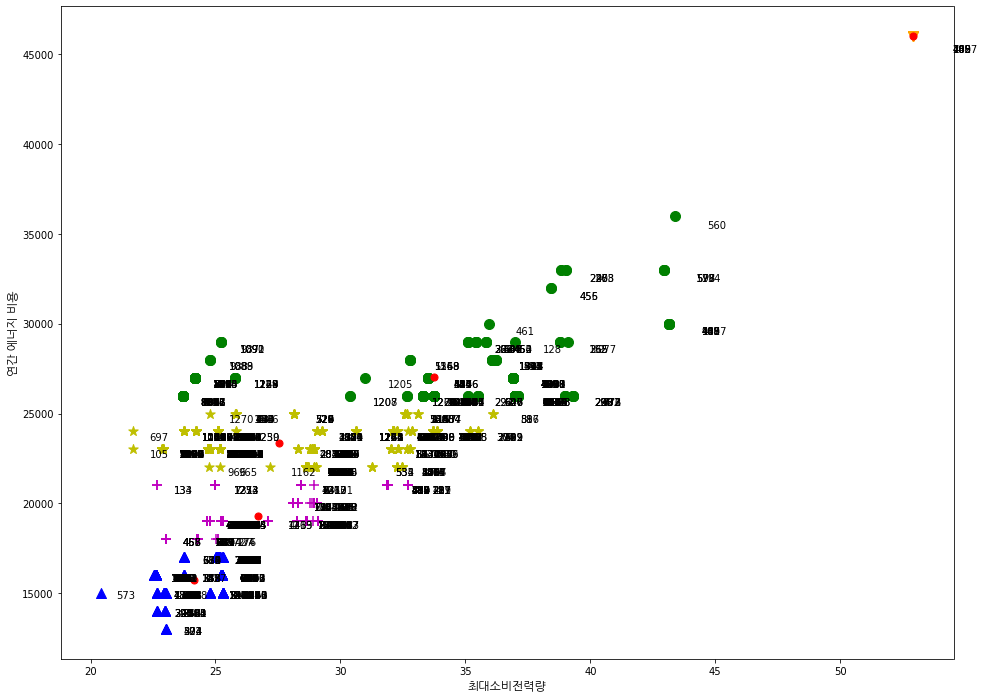

In [13]:
mark = ['*','^','o','v','+']
colr = ['y','b','g','orange','m']
plt.figure(figsize=(16,12))

plt.xlabel('최대소비전력량', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))
plt.ylabel('연간 에너지 비용', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))

for n in range(KmchFridge_part.shape[0]):
    label=kmeans.labels_[n]
    plt.scatter(KmchFridge_part['최대소비전력량'][n], KmchFridge_part['연간 에너지 비용'][n],
                c=colr[label], marker=mark[label],s=100)
    plt.text(KmchFridge_part['최대소비전력량'][n]*1.03, KmchFridge_part['연간 에너지 비용'][n]*0.98,
             KmchFridge_part.index[n])
for i in range(kmeans.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c='r',s=50)

# 5. Outlier Check

In [14]:
### 위 그래프에서 확인할 수 있는 '연간 에너지 비용'이 45,000보다 큰 값들은 이상치로 간주하고 drop함
outlier = KmchFridge_part[KmchFridge_part['연간 에너지 비용']>45000]
outlier_idx = outlier.index

for i in range(len(outlier_idx)):
    KmchFridge_cleaned = KmchFridge_part.drop(index=outlier_idx)

In [15]:
### outlier로 간주된 데이터들의 정보 확인
for i in range(len(outlier_idx)):
    print(app.iloc[outlier.index[i],:],
         '\n'*2)

신청번호                101980034
품목명                  전기냉장고(구)
모델명                   KSN3565
등급                   최저소비효율미달
최대소비전력량                  29.3
용량                        341
시간당 이산화탄소 배출량(g)          NaN
연간 에너지 비용                 NaN
Name: 162, dtype: object 


신청번호                101960231
품목명                  전기냉장고(구)
모델명                   R-B53CB
등급                   최저소비효율미달
최대소비전력량                    44
용량                        530
시간당 이산화탄소 배출량(g)          NaN
연간 에너지 비용                 NaN
Name: 200, dtype: object 


신청번호                101960140
품목명                  전기냉장고(구)
모델명                 GT-483AQN
등급                   최저소비효율미달
최대소비전력량                  34.5
용량                        480
시간당 이산화탄소 배출량(g)          NaN
연간 에너지 비용                 NaN
Name: 469, dtype: object 


신청번호                  101970008
품목명                    전기냉장고(구)
모델명                 FRB-4650NTC
등급                     최저소비효율미달
최대소비전력량                    39.7
용량                          456
시간당 

# 6. New Data Subset
> ### KmchFridge_cleaned

In [16]:
### drop한 column에 의해 IndexError가 발생하지 않도록 하기 위해 새로운 columnIndex 생성 후 설정
KmchFridge_cleaned['Num'] = np.arange(1397)
KmchFridge_cleaned.set_index('Num', inplace=True)
KmchFridge_cleaned.head()

,최대소비전력량,연간 에너지 비용,클러스터
Num,,,
0,25.30,19000,4
1,25.28,19000,4
2,25.28,19000,4
3,23.74,16000,1
4,28.41,21000,4


# 7. Scaling by StandardScaler

In [17]:
KmchFridge_cleaned[:] = scaler.fit_transform(KmchFridge_cleaned[:])
KmchFridge_cleaned.head()

,최대소비전력량,연간 에너지 비용,클러스터
Num,,,
0,-0.575308,-0.751809,1.695916
1,-0.579654,-0.751809,1.695916
2,-0.579654,-0.751809,1.695916
3,-0.914301,-1.530562,-0.255109
4,0.100506,-0.232641,1.695916


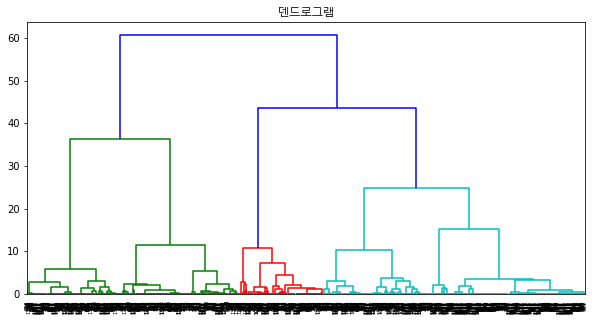

In [18]:
for i in range(len(KmchFridge_part)):
    KmchFridge_part['연간 에너지 비용'][i] = int(KmchFridge_part['연간 에너지 비용'][i])
    
Z = linkage(KmchFridge_cleaned, metric='euclidean', method='ward')
plt.figure(figsize=(10,5))
plt.title('덴드로그램', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))

dendrogram(Z, labels=KmchFridge_cleaned.index)
plt.show()

# 8. Scaled Data Clustering

## 8-1. n_clusters = 5

In [19]:
from sklearn.cluster import KMeans
kmeans_s = KMeans(n_clusters=5).fit(KmchFridge_cleaned)

print(kmeans_s.n_clusters)
centers = kmeans_s.cluster_centers_

5


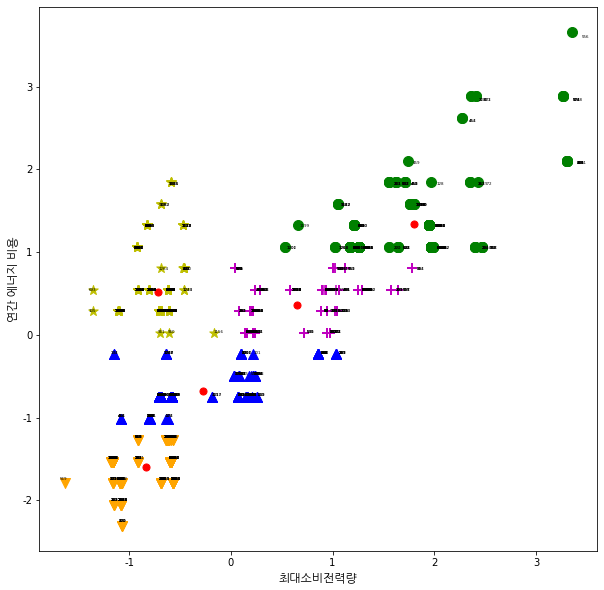

In [20]:
mark = ['*','^','o','v','+']
colr = ['y','b','g','orange','m']
plt.figure(figsize=(10,10))

plt.xlabel('최대소비전력량', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))
plt.ylabel('연간 에너지 비용', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))

for n in range(KmchFridge_cleaned.shape[0]):
    label=kmeans_s.labels_[n]
    plt.scatter(KmchFridge_cleaned['최대소비전력량'][n], KmchFridge_cleaned['연간 에너지 비용'][n],
                c=colr[label], marker=mark[label],s=100)
    plt.text(KmchFridge_cleaned['최대소비전력량'][n]*1.03, KmchFridge_cleaned['연간 에너지 비용'][n]*0.98,
             KmchFridge_cleaned.index[n], fontsize=4)
for i in range(kmeans_s.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c='r',s=50)

## 8-2. n_clusters = 6

In [21]:
from sklearn.cluster import KMeans
kmeans_s2 = KMeans(n_clusters=6).fit(KmchFridge_cleaned)

print(kmeans_s2.n_clusters)
centers = kmeans_s2.cluster_centers_

6


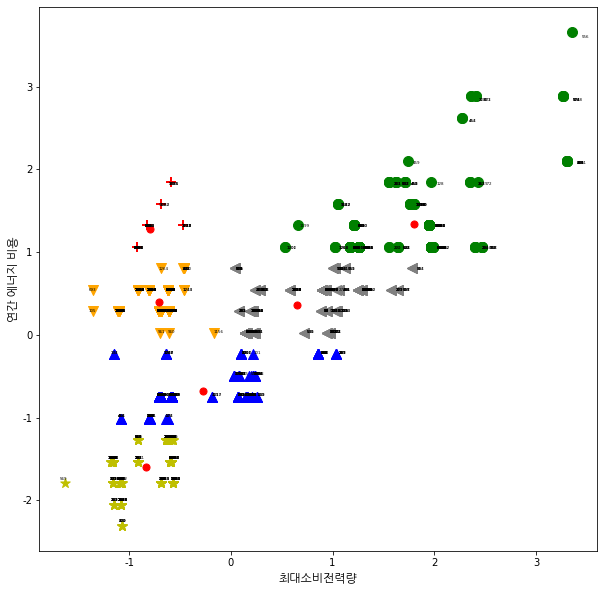

In [22]:
mark = ['*','^','o','v','+','<']
colr = ['y','b','g','orange','r','gray']
plt.figure(figsize=(10,10))

plt.xlabel('최대소비전력량', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))
plt.ylabel('연간 에너지 비용', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))

for n in range(KmchFridge_cleaned.shape[0]):
    label=kmeans_s2.labels_[n]
    plt.scatter(KmchFridge_cleaned['최대소비전력량'][n], KmchFridge_cleaned['연간 에너지 비용'][n],
                c=colr[label], marker=mark[label],s=100)
    plt.text(KmchFridge_cleaned['최대소비전력량'][n]*1.03, KmchFridge_cleaned['연간 에너지 비용'][n]*0.98,
             KmchFridge_cleaned.index[n], fontsize=4)
for i in range(kmeans_s2.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c='r',s=50)

## 8-3. n_clusters = 7

In [23]:
from sklearn.cluster import KMeans
kmeans_s3 = KMeans(n_clusters=7).fit(KmchFridge_cleaned)

print(kmeans_s3.n_clusters)
centers = kmeans_s3.cluster_centers_

7


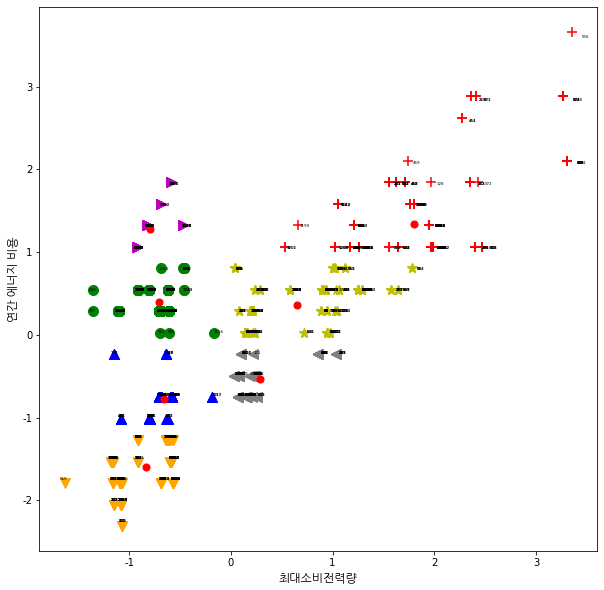

In [24]:
mark = ['*','^','o','v','+','<','>']
colr = ['y','b','g','orange','r','gray','m']
plt.figure(figsize=(10,10))

plt.xlabel('최대소비전력량', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))
plt.ylabel('연간 에너지 비용', fontproperties = font_manager.FontProperties(fname=fontpath, size=12))

for n in range(KmchFridge_cleaned.shape[0]):
    label=kmeans_s3.labels_[n]
    plt.scatter(KmchFridge_cleaned['최대소비전력량'][n], KmchFridge_cleaned['연간 에너지 비용'][n],
                c=colr[label], marker=mark[label],s=100)
    plt.text(KmchFridge_cleaned['최대소비전력량'][n]*1.03, KmchFridge_cleaned['연간 에너지 비용'][n]*0.98,
             KmchFridge_cleaned.index[n], fontsize=4)
for i in range(kmeans_s3.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c='r',s=50)